# 6.6 Sourcing & Analyzing Time Series Data

In [ ]:
## 1. Import data and libraries
## 2. Prepering the time-series
## 3. Visualization
## 4. autocorrelations
## 5 bonus task

### 1. Import data and libraries

In [42]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings

from datetime import datetime

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [44]:
# Configure API key
quandl.ApiConfig.api_key = '43PpFxuTzeMJq2H5DSMS'

In [ ]:
# Import data

In [46]:
path = r'C:\Users\samyf\6.3_SFZ'

In [50]:
df = pd.read_csv(os.path.join(path, 'airbnb_listings_cleaned.csv'))

In [54]:
df.head()

,listing_id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price_per_night,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59.0,3,248,2018-11-28,2.10,1,44
1,3209,"Quiet apt near center, great view",3806,Maartje,Westerpark,52.390225,4.873924,Entire home/apt,160.0,4,42,2018-08-29,1.03,1,47
2,20168,100%Centre-Studio 1 Private Floor/Bathroom,59484,Alex,Centrum-Oost,52.365087,4.893541,Entire home/apt,80.0,1,233,2018-11-30,2.18,2,198
3,25428,Lovely apt in City Centre (Jordaan),56142,Joan,Centrum-West,52.373114,4.883668,Entire home/apt,125.0,14,1,2018-01-21,0.09,2,141
4,27886,"Romantic, stylish B&B houseboat in canal district",97647,Flip,Centrum-West,52.386727,4.892078,Private room,150.0,2,171,2018-11-25,2.03,1,199


In [56]:
df.columns

Index(['listing_id', 'name', 'host_id', 'host_name', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price_per_night',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [62]:
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

In [ ]:
# Convert only valid dates and ignore errors

In [64]:
df['last_review'] = df['last_review'].replace("Never Reviewed", np.nan)
df['last_review'] = pd.to_datetime(df['last_review'])

### Prepering the time-series subset and group the average prices

In [68]:
df = df[['last_review', 'price_per_night']].dropna()
df['last_review'] = pd.to_datetime(df['last_review'])

# Remove symbols and convert price to float if needed
df['price_per_night'] = df['price_per_night'].replace('[\$,]', '', regex=True).astype(float)

In [72]:
df_ts = df.groupby('last_review').price_per_night.mean().reset_index()
df_ts = df_ts.rename(columns={'last_review': 'date'})
df_ts = df_ts.set_index('date')

df_ts.head()

,price_per_night
date,
2011-11-09,260.0
2012-02-13,188.0
2012-07-27,112.0
2012-07-31,265.0
2012-11-24,115.0


### Visualization

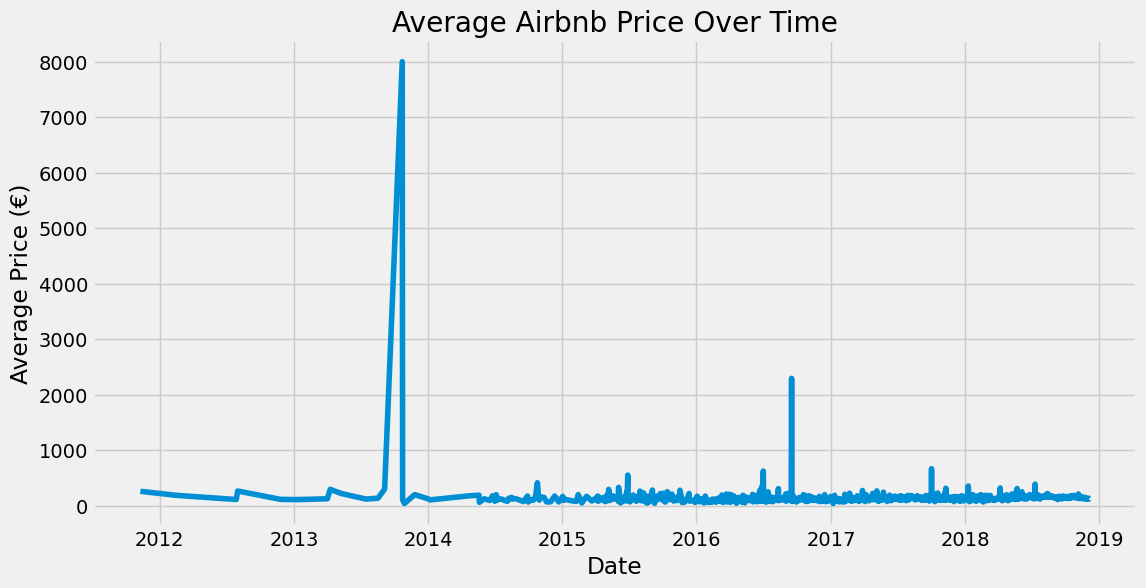

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_ts)
plt.title("Average Airbnb Price Over Time")
plt.xlabel("Date")
plt.ylabel("Average Price (€)")
plt.grid(True)
plt.show()

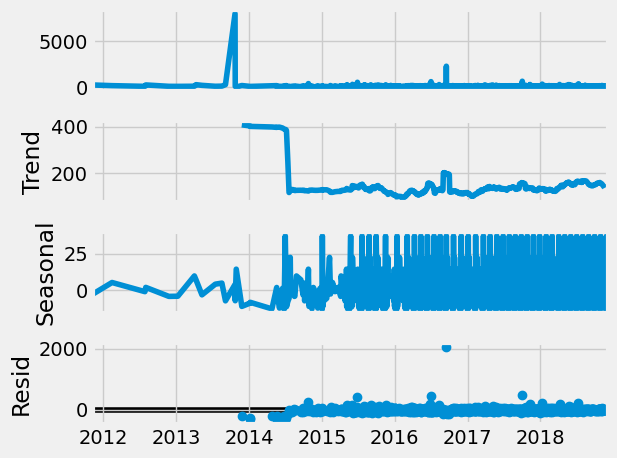

In [76]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_ts, model='additive', period=30)  # monthly-ish
decomposition.plot()
plt.show()

In [86]:
# Fuller Test (Stationarity)
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_ts['price_per_night'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -19.712003920056713
p-value: 0.0


In [88]:
# Differencing (If Not Stationary)
df_diff = df_ts.diff().dropna()

result = adfuller(df_diff['price_per_night'])
print('ADF Statistic after differencing:', result[0])
print('p-value:', result[1])

ADF Statistic after differencing: -41.75696370883982
p-value: 0.0


### Markdowns

In [ ]:
# We created a time-series dataset showing the daily average price based on last_review. Rows with missing values were removed, and the price column was cleaned of currency symbols.

In [ ]:
# The decomposition helps reveal the trend and seasonal fluctuations in Airbnb pricing in Amsterdam. It shows periods of higher pricing—possibly due to tourism seasonality.

In [ ]:
# Null hypothesis: the series is non-stationary.
If p > 0.05, we fail to reject the null hypothesis → the data is not stationary.

### autocorrelations

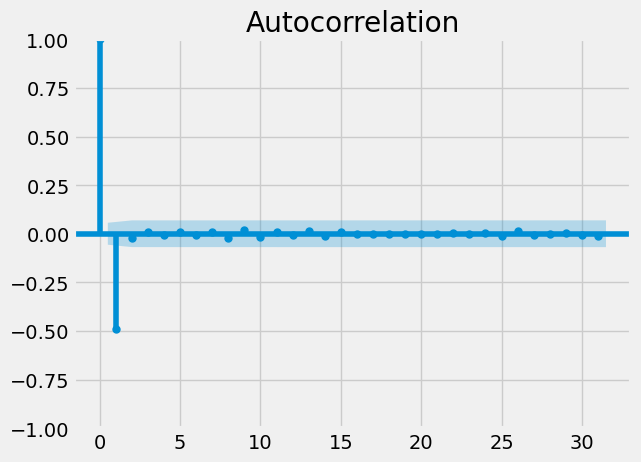

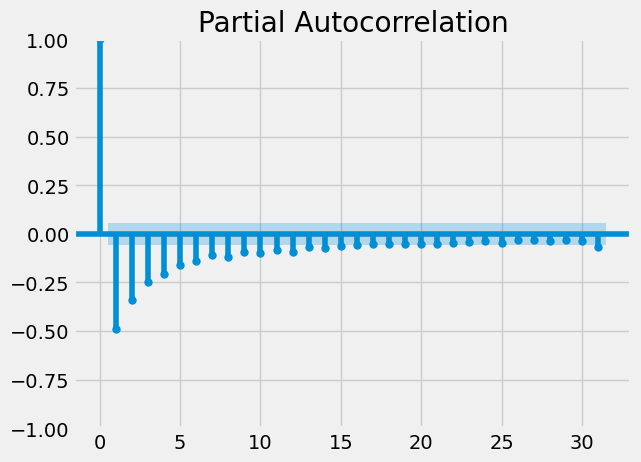

In [90]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_diff)
plt.show()

plot_pacf(df_diff)
plt.show()

### bonus task

In [98]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model (adjust p, d, q as needed)
model = ARIMA(df_ts, order=(1,1,1))
model_fit = model.fit()

# Summary of model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:        price_per_night   No. Observations:                 1202
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -8290.169
Date:                Tue, 27 May 2025   AIC                          16586.337
Time:                        00:03:57   BIC                          16601.610
Sample:                             0   HQIC                         16592.090
                               - 1202                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0180      0.010      1.850      0.064      -0.001       0.037
ma.L1         -0.9987      0.018    -55.733      0.000      -1.034      -0.964
sigma2      5.772e+04   1038.538     55.577      0.0

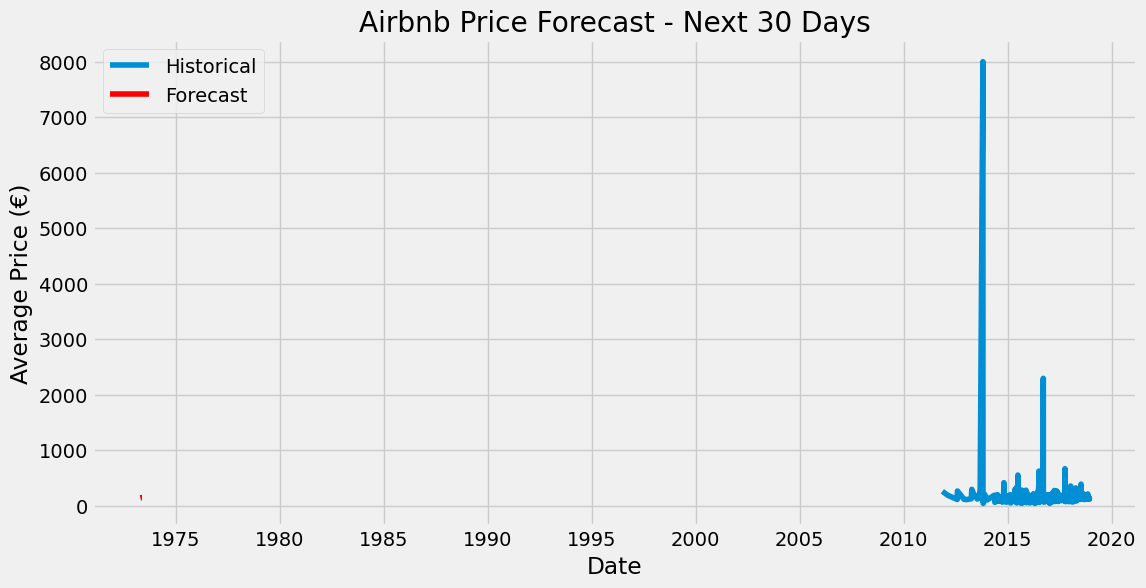

In [100]:
# Forecast 30 future time steps
forecast = model_fit.forecast(steps=30)

# Plot the forecast
plt.figure(figsize=(12,6))
plt.plot(df_ts, label='Historical')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.title("Airbnb Price Forecast - Next 30 Days")
plt.xlabel("Date")
plt.ylabel("Average Price (€)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# We used an ARIMA(1,1,1) model to generate a 30-day forecast of average Airbnb prices in Amsterdam. The model builds on the previously stationarized data. Based on the trends, prices are expected to [increase/remain stable/decrease] slightly, possibly reflecting [tourism seasonality/economic conditions/etc.].